### Read eqd Files with Numpy and Plot

In [1]:
# import all the necessary modules
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
# https://freeqdsk.readthedocs.io/en/stable/geqdsk.html
from freeqdsk import geqdsk
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# read the ./eqds/circ_mtm_07_09.eqd file as a text file, selecting only the first 3 columns
#filename = "./geqdsks/ITER_10MA.geqdsk"
#filename = "D:\Codes\eqdsk2py\geqdsks\JINTRAC_15MA_H-mode_513x1024_ppfseq23585.eqdsk"
filename = "geqdsks\ITER_10MA.geqdsk"

In [3]:
with open(filename, "r") as f:
    data = geqdsk.read(f)

In [4]:
data.keys()

dict_keys(['comment', 'int', 'nx', 'ny', 'rdim', 'zdim', 'rcentr', 'rleft', 'zmid', 'rmagx', 'zmagx', 'simagx', 'sibdry', 'bcentr', 'cpasma', 'fpol', 'pres', 'ffprime', 'pprime', 'psi', 'qpsi', 'nbdry', 'nlim', 'rbdry', 'zbdry', 'rlim', 'zlim'])

In [5]:
# len of data['psi']
psi = data['psi']
print(psi.shape)
type(psi)

(256, 257)


numpy.ndarray

>The 2D grid is instead expressed on a linearly spaced grid extending the range [rleft, rleft + rdim] in the R direction and [zmid - zdim/2, zmid + zdim/2] in the Z direction.

In [6]:
# create a meshgrid to plot the psi values
x = np.linspace(data['rleft'], data['rleft'] + data['rdim'], data['nx'])
y = np.linspace(data['zmid'] - data['zdim'] / 2, data['zmid'] + data['zdim'] / 2, data['ny'])
xx, yy = np.meshgrid(x, y)

In [7]:
# rotate the psi matrix by 90 degrees to match the plot
psi = psi.T

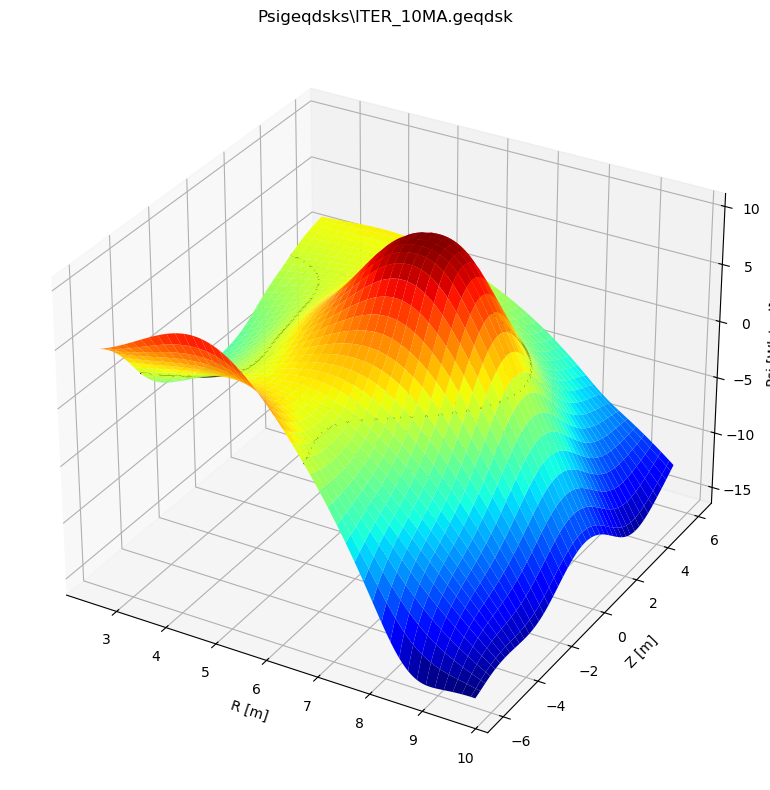

In [8]:
# plot the psi values
# create a figure
fig = plt.figure()
# set figure size
fig.set_size_inches(8, 8)

# create an axis 3D
ax = fig.add_subplot(111, projection='3d')
# plot the surface
ax.plot_surface(xx, yy, psi, cmap='jet')
# add x, y, z labels
ax.set_xlabel('R [m]')
ax.set_ylabel('Z [m]')
ax.set_zlabel('Psi [Wb/rad]')
# add a title
ax.set_title('Psi'+filename)

# add a contour plot at psi = 0
plt.contour(xx, yy, psi, levels=[0], colors='black')


plt.tight_layout()
plt.show()

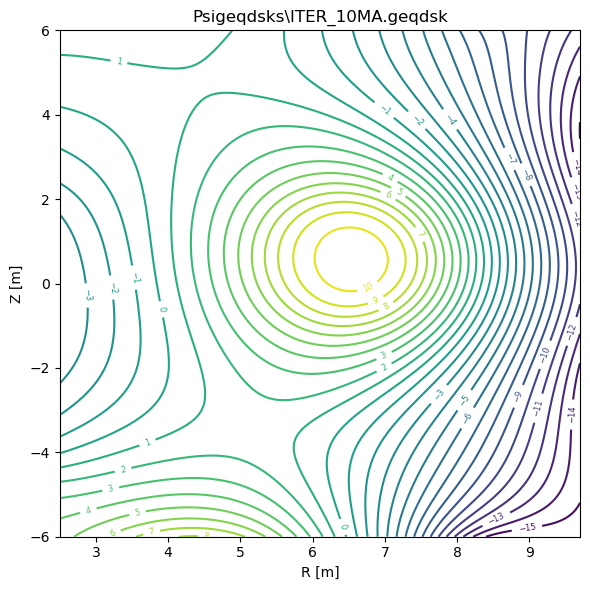

In [9]:
# add a 2D contour plot
fig = plt.figure()
fig.set_size_inches(6,6)
ax = fig.add_subplot(111)
#ax.contour(xx, yy, psi, levels=40, colors='black')
ax.set_xlabel('R [m]')
ax.set_ylabel('Z [m]')
ax.set_title('Psi'+filename)
# show psi levels inside the plot with numbers
plt.clabel(ax.contour(xx, yy, psi, levels=30), inline=1, fontsize=6)

plt.tight_layout()
plt.show()

In [10]:
# plot interactive 3D plot with plotly
import plotly.graph_objects as go

fig = go.Figure(data=[go.Surface(z=psi/10, x=x, y=y)])
fig.update_layout(title='Psi'+filename,
                  autosize=False,
                  width=500, height=500,
                  margin=dict(l=50, r=50, b=50, t=50))
# add a contour plot at psi = 0
fig.show()

In [11]:
x.shape, y.shape, psi.shape

((256,), (257,), (257, 256))

In [12]:
# create a 2D spline
bvq_spline = sp.interpolate.RectBivariateSpline(x, y, psi.T);

In [13]:
x.shape, y.shape, psi.T.shape

((256,), (257,), (256, 257))

In [14]:
x2 = np.linspace(data['rleft'], data['rleft'] + data['rdim'], 1*data['nx'])
y2 = np.linspace(data['zmid'] - data['zdim'] / 2, data['zmid'] + data['zdim'] / 2, 1*data['ny'])
xx2, yy2 = np.meshgrid(x2, y2)

# changing this to confirm that the spline is working

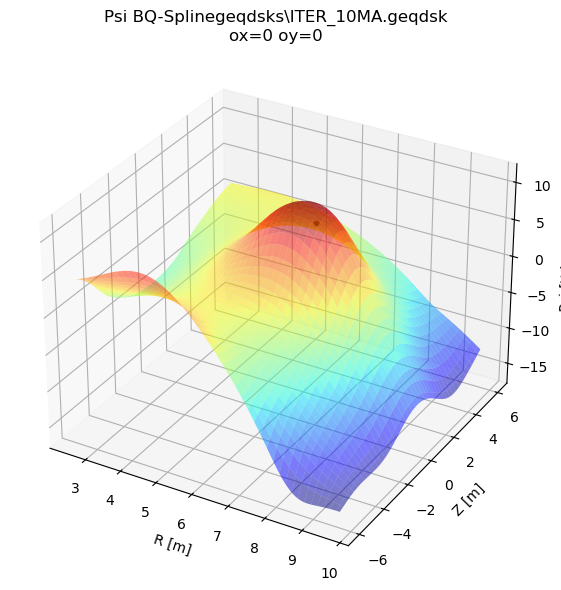

In [15]:
# plot the psi values
# create a figure
fig = plt.figure()
# set figure size
fig.set_size_inches(6, 6)

# create an axis 3D
ax = fig.add_subplot(111, projection='3d')
# plot the surface

# order of the derivatives in x and y respectively
ox = 0; oy = 0
ax.plot_surface(xx2, yy2, bvq_spline(x2, y2, ox, oy).T, cmap='jet', alpha=0.5)
# add x, y, z labels
ax.set_xlabel('R [m]')
ax.set_ylabel('Z [m]')
ax.set_zlabel('Psi [Wb/rad]')
# add a title
ax.set_title('Psi BQ-Spline'+filename+'\nox='+str(ox)+' oy='+str(oy))

ax.scatter(7, 0, bvq_spline(7, 0), c='black', marker='o', s=10)

plt.tight_layout()
plt.show()

In [16]:
res = sp.optimize.minimize(lambda x: bvq_spline(x[0], x[1]), x0=[9, 5], \
                           method='Nelder-Mead', \
                            bounds=[(data['rleft'], data['rleft'] + data['rdim']), 
                                    (data['zmid'] - data['zdim'] / 2, data['zmid'] + data['zdim'] / 2)])

In [17]:
res

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: -15.032697108113657
             x: [ 9.700e+00  3.626e+00]
           nit: 27
          nfev: 50
 final_simplex: (array([[ 9.700e+00,  3.626e+00],
                       [ 9.700e+00,  3.626e+00],
                       [ 9.700e+00,  3.626e+00]]), array([-1.503e+01, -1.503e+01, -1.503e+01]))

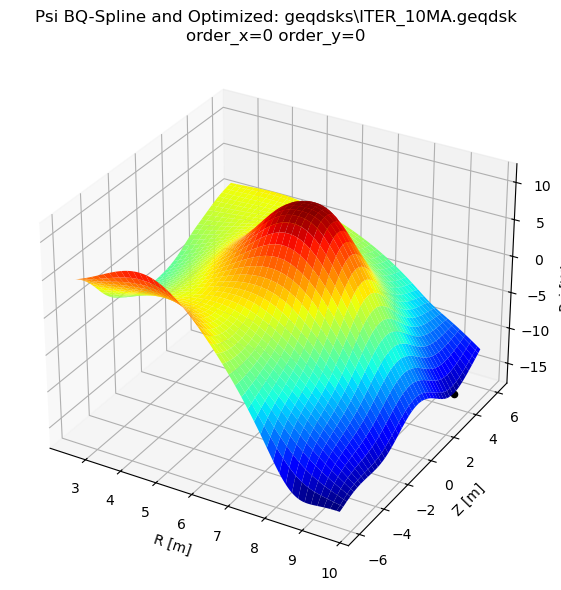

In [18]:
# plot the bvq_spline again with a point at the minimum on the surface
# plot the psi values
# create a figure
fig = plt.figure()
# set figure size
fig.set_size_inches(6, 6)

# create an axis 3D
ax = fig.add_subplot(111, projection='3d')
# plot the surface

# order of the derivatives in x and y respectively
ox = 0; oy = 0
ax.plot_surface(xx2, yy2, bvq_spline(x2, y2).T, cmap='jet')

# add a point at the minimum
ax.scatter(res.x[0], res.x[1], res.fun, color='black')


# add x, y, z labels
ax.set_xlabel('R [m]')
ax.set_ylabel('Z [m]')
ax.set_zlabel('Psi [Wb/rad]')
# add a title
ax.set_title('Psi BQ-Spline and Optimized: '+filename+'\norder_x='+str(ox)+' order_y='+str(oy))

# set view angle
#ax.view_init(30, 0)

plt.tight_layout()
plt.show()


In [19]:
fig = go.Figure(data=[go.Surface(z=bvq_spline(x2, y2).T /10, x=x2, y=y2)])
fig.update_layout(title='Psi BQ-Spline'+filename+'\nox='+str(ox)+' oy='+str(oy),
                  autosize=True,
                  width=600, height=600,
                  margin=dict(l=50, r=50, b=50, t=50))

# add a point at the minimum
fig.add_trace(go.Scatter3d(x=[res.x[0]], y=[res.x[1]], z=[res.fun / 10], mode='markers', marker=dict(color='black')))
fig.update_layout()
fig.show()
